In [71]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,mean_absolute_error
from sklearn.model_selection import LeaveOneOut, KFold , train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy

In [66]:
X = np.load("/VS dir/PlayingSpiroData/Spiro-Data/npy_file/FEV1_FEATURES_60.npy")
y = np.load("/VS dir/PlayingSpiroData/Spiro-Data/npy_file/FEV1_LABELS_60.npy")

# Removing erroreneous data

X= pd.DataFrame(X).drop(index=[23,55,4,9,52,44,45,33,43,20,1,50])
y= pd.DataFrame(y).drop(index=[23,55,4,9,52,44,45,33,43,20,1,50])

X.shape

(48, 166)

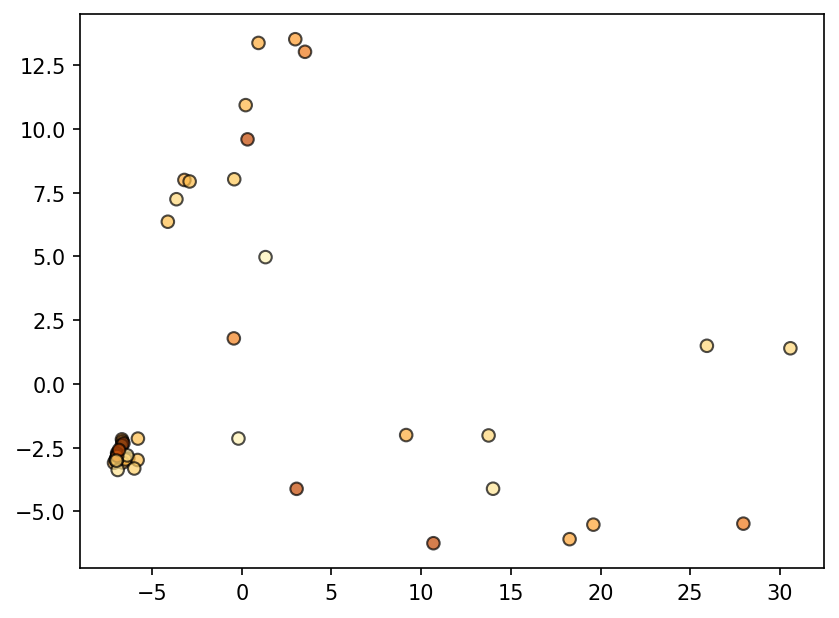

In [16]:
Xt = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
PC2 = pd.DataFrame(pca.fit_transform(Xt))
plt.figure(dpi=150)
plt.scatter(PC2[0],PC2[1],c=y,cmap='YlOrBr',edgecolors='k',alpha=0.7)
plt.show()

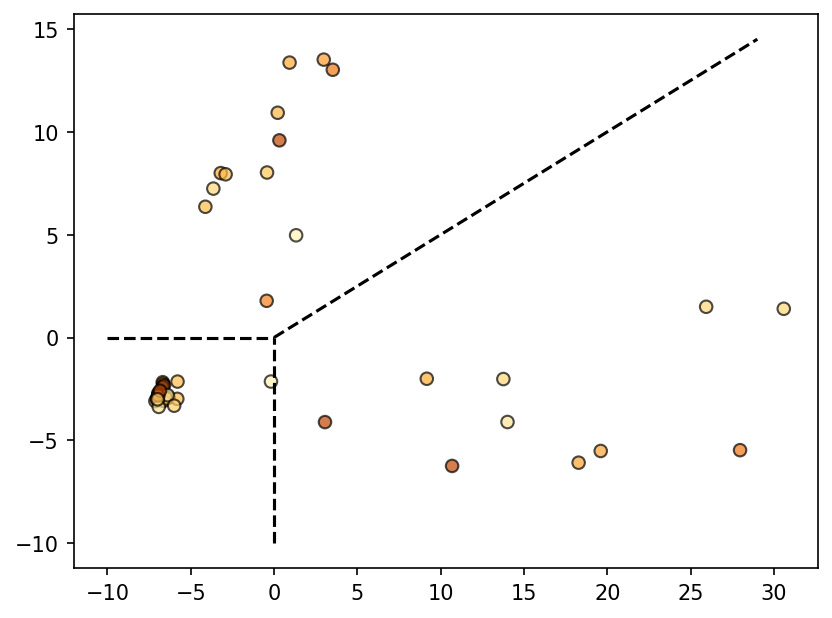

In [5]:
plt.figure(dpi=150)
plt.scatter(PC2[0],PC2[1],c=y,cmap='YlOrBr',edgecolors='k',alpha=0.7)

plt.plot([0,0,0,0,0],[-10,-7.5,-5.0,-2.5,0],linestyle='dashed',color='black')
plt.plot([-10,-7.5,-5,-2.5,0],[0,0,0,0,0],linestyle='dashed',color='black')
plt.plot([i for i in range(0,30)],[i/2 for i in range(0,30)],linestyle='dashed',color='black')

plt.show()

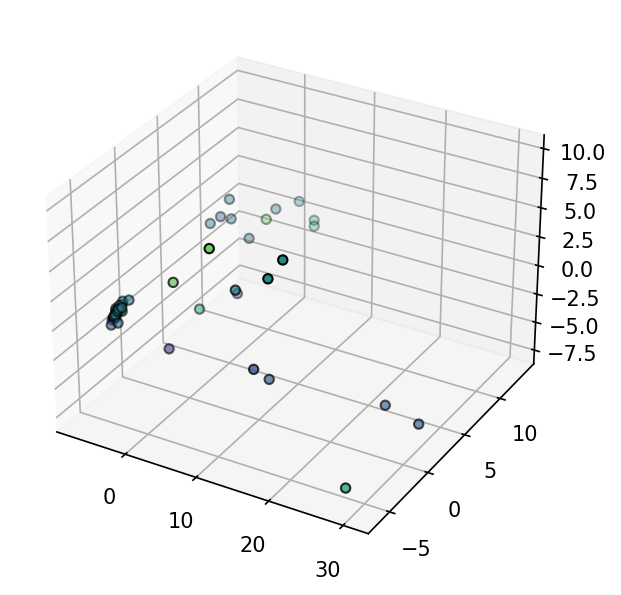

In [6]:
Xt = StandardScaler().fit_transform(X)
pca = PCA(n_components=3)
PC3 = pd.DataFrame(pca.fit_transform(Xt))
fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection='3d')
ax.scatter(PC3[0],PC3[1],PC3[2],c=y,edgecolors='k')
plt.show()

## How many features are enough??

In [53]:
Xt = StandardScaler().fit_transform(X)

# letting it run for as many features it can.
pca = PCA()

PC = pca.fit_transform(Xt)

In [54]:
# Explained variances from the PCA
np.around(pca.explained_variance_,decimals=2)

array([1.0423e+02, 3.0600e+01, 1.0530e+01, 4.9800e+00, 2.8300e+00,
       2.2800e+00, 1.8800e+00, 1.7400e+00, 1.4500e+00, 1.0900e+00,
       9.9000e-01, 9.8000e-01, 7.7000e-01, 6.7000e-01, 6.0000e-01,
       5.5000e-01, 4.6000e-01, 3.9000e-01, 3.3000e-01, 3.1000e-01,
       2.7000e-01, 2.6000e-01, 2.3000e-01, 2.0000e-01, 1.9000e-01,
       1.7000e-01, 1.3000e-01, 1.1000e-01, 1.0000e-01, 8.0000e-02,
       6.0000e-02, 3.0000e-02, 2.0000e-02, 1.0000e-02, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00])

In [55]:
# Lets check how many of them are greater than zero
np.count_nonzero(np.around(pca.explained_variance_,decimals=2))

34

In [56]:
# Explained variances ratio from the PCA
np.around(pca.explained_variance_ratio_*100, decimals  = 2)

array([6.148e+01, 1.805e+01, 6.210e+00, 2.940e+00, 1.670e+00, 1.340e+00,
       1.110e+00, 1.030e+00, 8.500e-01, 6.400e-01, 5.900e-01, 5.800e-01,
       4.600e-01, 3.900e-01, 3.500e-01, 3.200e-01, 2.700e-01, 2.300e-01,
       1.900e-01, 1.900e-01, 1.600e-01, 1.500e-01, 1.300e-01, 1.200e-01,
       1.100e-01, 1.000e-01, 8.000e-02, 7.000e-02, 6.000e-02, 5.000e-02,
       3.000e-02, 2.000e-02, 1.000e-02, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00])

In [57]:
# Lets check how many of them are greater than zero
np.count_nonzero(np.around(pca.explained_variance_ratio_*100, decimals  = 2))

33

### 34 or 33 features are enough for our use. lets use 34 then.

In [64]:
Xt = StandardScaler().fit_transform(X)

# letting it run for as 34 features.
pca = PCA(n_components=34)

PC34 = pd.DataFrame(pca.fit_transform(Xt))

### First Lets try building Random forest using all features.

In [67]:
RF = RandomForestRegressor( n_jobs=-1, bootstrap=True, criterion='squared_error', 
                                  n_estimators=500,  max_features=1.0, max_depth=100,  
                                  min_samples_leaf=1, min_samples_split=5 ,random_state=42)

# Total number of the splits
tot = len(X)
# Instantiating Leave_One_Out split function.
loo = LeaveOneOut()

prog = 0
y_GT = []
y_PT = []
abserror=[]

print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=")
print("Random Forest Regressor for FEV1")

# For every split obtained by Leave_One_Out split function.
for i,(train_index, test_index) in enumerate(loo.split(X)):
    
    # To show some sort of progress.
    prog = prog + 1
    print("Progress : {0}/{1}".format(prog,tot),end = '\r')

    # Test-train split for the fold.
    X_Train, X_Test = X.iloc[train_index],X.iloc[test_index]
    y_Train, y_Test = y.iloc[train_index],y.iloc[test_index]
    
    # Training new Random Forest ensemble.
    RF.fit(X_Train, np.ravel(y_Train))
    pred = RF.predict(X_Test)  

    # Storing the values of Ground truth and Predicted value for future use.
    y_GT.append(y_Test.iloc[0,0])
    y_PT.append(pred[0]) 


print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=")
print("Random forest metrics with reduced feature set")
print("\tMean Absolute Percentage Error : " , 100 * mean_absolute_percentage_error(y_GT,y_PT))
print("\tMean Aabsolute Error : " , mean_absolute_error(y_GT,y_PT))
print("\tMean Square Error : " , mean_squared_error(y_GT,y_PT))
print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=")

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=
Random Forest Regressor for FEV1
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Random forest metrics with reduced feature set
	Mean Absolute Percentage Error :  6.224289571382804
	Mean Aabsolute Error :  0.18603059223184223
	Mean Square Error :  0.06056913442778411
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


### Lets try building Random forest using these features and lets see what happens .

In [65]:
X_new = PC34
y_new = y

RF_new = RandomForestRegressor( n_jobs=-1, bootstrap=True, criterion='squared_error', 
                                  n_estimators=500,  max_features=1.0, max_depth=100,  
                                  min_samples_leaf=1, min_samples_split=5 ,random_state=42)

# Total number of the splits
tot = len(X_new)
# Instantiating Leave_One_Out split function.
loo = LeaveOneOut()

prog = 0
y_GT = []
y_PT = []
abserror=[]

print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=")
print("Random Forest Regressor for FEV1")

# For every split obtained by Leave_One_Out split function.
for i,(train_index, test_index) in enumerate(loo.split(X)):
    
    # To show some sort of progress.
    prog = prog + 1
    print("Progress : {0}/{1}".format(prog,tot),end = '\r')

    # Test-train split for the fold.
    X_Train, X_Test = X_new.iloc[train_index],X_new.iloc[test_index]
    y_Train, y_Test = y_new.iloc[train_index],y_new.iloc[test_index]
    
    # Training new Random Forest ensemble.
    RF_new.fit(X_Train, np.ravel(y_Train))
    pred = RF_new.predict(X_Test)  

    # Storing the values of Ground truth and Predicted value for future use.
    y_GT.append(y_Test.iloc[0,0])
    y_PT.append(pred[0]) 


print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=")
print("Random forest metrics with reduced feature set")
print("\tMean Absolute Percentage Error : " , 100 * mean_absolute_percentage_error(y_GT,y_PT))
print("\tMean Aabsolute Error : " , mean_absolute_error(y_GT,y_PT))
print("\tMean Square Error : " , mean_squared_error(y_GT,y_PT))
print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=")

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=
Random Forest Regressor for FEV1
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Random forest metrics with reduced feature set
	Mean Absolute Percentage Error :  5.99203512860943
	Mean Aabsolute Error :  0.1793862422242113
	Mean Square Error :  0.05967931632932488
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


#### MAPE Error redued from 6.22 to 5.99. Not much of a difference actually.

## What if we use only two features (Just for fun).

In [68]:
X_new = PC2
y_new = y

RF_new = RandomForestRegressor( n_jobs=-1, bootstrap=True, criterion='squared_error', 
                                  n_estimators=500,  max_features=1.0, max_depth=100,  
                                  min_samples_leaf=1, min_samples_split=5 ,random_state=42)

# Total number of the splits
tot = len(X_new)
# Instantiating Leave_One_Out split function.
loo = LeaveOneOut()

prog = 0
y_GT = []
y_PT = []
abserror=[]

print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=")
print("Random Forest Regressor for FEV1")

# For every split obtained by Leave_One_Out split function.
for i,(train_index, test_index) in enumerate(loo.split(X)):
    
    # To show some sort of progress.
    prog = prog + 1
    print("Progress : {0}/{1}".format(prog,tot),end = '\r')

    # Test-train split for the fold.
    X_Train, X_Test = X_new.iloc[train_index],X_new.iloc[test_index]
    y_Train, y_Test = y_new.iloc[train_index],y_new.iloc[test_index]
    
    # Training new Random Forest ensemble.
    RF_new.fit(X_Train, np.ravel(y_Train))
    pred = RF_new.predict(X_Test)  

    # Storing the values of Ground truth and Predicted value for future use.
    y_GT.append(y_Test.iloc[0,0])
    y_PT.append(pred[0]) 


print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=")
print("Random forest metrics with reduced feature set")
print("\tMean Absolute Percentage Error : " , 100 * mean_absolute_percentage_error(y_GT,y_PT))
print("\tMean Aabsolute Error : " , mean_absolute_error(y_GT,y_PT))
print("\tMean Square Error : " , mean_squared_error(y_GT,y_PT))
print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=")

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=
Random Forest Regressor for FEV1
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Random forest metrics with reduced feature set
	Mean Absolute Percentage Error :  7.0724739221268
	Mean Aabsolute Error :  0.21340784359737505
	Mean Square Error :  0.0822044135193409
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=


### Lets get back to 2 features

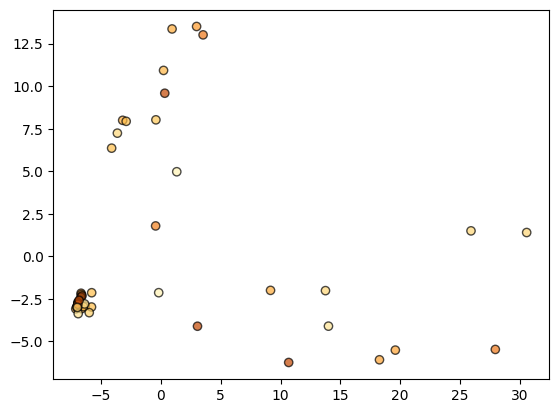

In [70]:
Xt = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
PC2 = pd.DataFrame(pca.fit_transform(Xt))
plt.scatter(PC2[0],PC2[1],c=y,cmap='YlOrBr',edgecolors='k',alpha=0.7)
plt.show()

### Using T-Sne

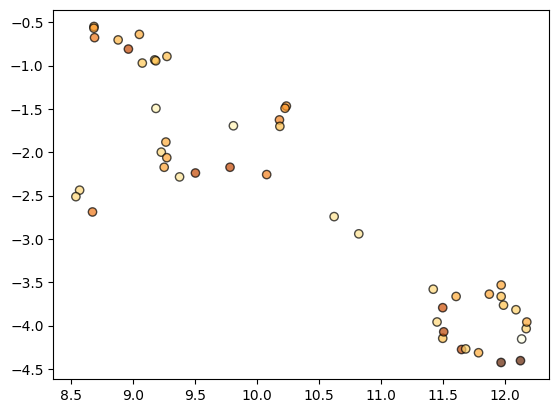

In [98]:
tsne = TSNE(n_components=2,perplexity=30,n_iter=10000)
tsne_X = pd.DataFrame(tsne.fit_transform(X))
plt.scatter(tsne_X[0],tsne_X[1],c=y,cmap='YlOrBr',edgecolors='k',alpha=0.7)
plt.show()

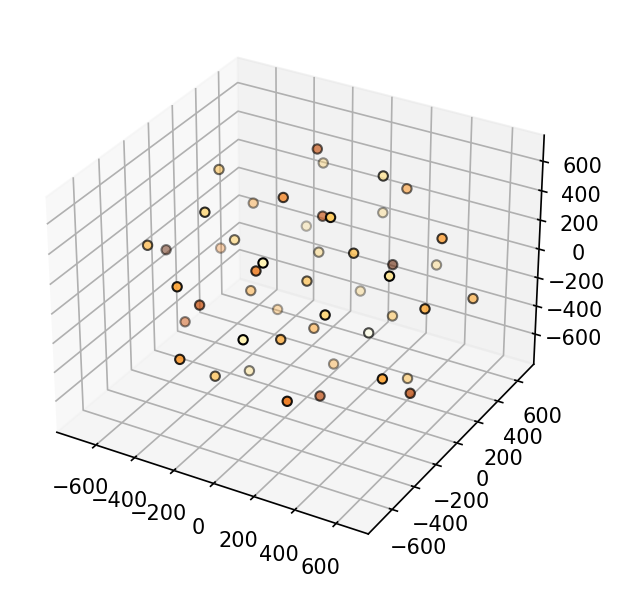

In [104]:
tsne = TSNE(n_components=3,perplexity=40,n_iter=10000)
tsne_X3 = pd.DataFrame(tsne.fit_transform(X))

fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection='3d')
ax.scatter(tsne_X3[0],tsne_X3[1],tsne_X3[2],c=y,cmap='YlOrBr',edgecolors='k')
plt.show()

### Running RF on tsne data

In [103]:
tsne = TSNE(n_components=2,perplexity=30,n_iter=10000)
tsne_X = pd.DataFrame(tsne.fit_transform(X))
X_new = tsne_X
y_new = y

RF_new = RandomForestRegressor( n_jobs=-1, bootstrap=True, criterion='squared_error', 
                                  n_estimators=500,  max_features=1.0, max_depth=100,  
                                  min_samples_leaf=1, min_samples_split=5 ,random_state=42)

# Total number of the splits
tot = len(X_new)
# Instantiating Leave_One_Out split function.
loo = LeaveOneOut()

prog = 0
y_GT = []
y_PT = []
abserror=[]

print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=")
print("Random Forest Regressor for FEV1")

# For every split obtained by Leave_One_Out split function.
for i,(train_index, test_index) in enumerate(loo.split(X)):
    
    # To show some sort of progress.
    prog = prog + 1
    print("Progress : {0}/{1}".format(prog,tot),end = '\r')

    # Test-train split for the fold.
    X_Train, X_Test = X_new.iloc[train_index],X_new.iloc[test_index]
    y_Train, y_Test = y_new.iloc[train_index],y_new.iloc[test_index]
    
    # Training new Random Forest ensemble.
    RF_new.fit(X_Train, np.ravel(y_Train))
    pred = RF_new.predict(X_Test)  

    # Storing the values of Ground truth and Predicted value for future use.
    y_GT.append(y_Test.iloc[0,0])
    y_PT.append(pred[0]) 


print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=")
print("Random forest metrics with reduced feature set")
print("\tMean Absolute Percentage Error : " , 100 * mean_absolute_percentage_error(y_GT,y_PT))
print("\tMean Aabsolute Error : " , mean_absolute_error(y_GT,y_PT))
print("\tMean Square Error : " , mean_squared_error(y_GT,y_PT))
print("=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=")

=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-==-=-=-=-=
Random Forest Regressor for FEV1
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Random forest metrics with reduced feature set
	Mean Absolute Percentage Error :  6.869018409382933
	Mean Aabsolute Error :  0.20539201793229878
	Mean Square Error :  0.06831464558225647
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
